In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from h3 import h3 
from shapely.geometry import shape
from shapely.geometry import Point

In [2]:
#nur die daten von 2017 einlesen, schon leicht bearbeitet(taxi id neu und trio id geloescht)
df=pd.read_csv('trips17small.csv')
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID
0,05/12/2017 09:00:00 PM,05/12/2017 09:15:00 PM,865.0,4.6,1.703132e+10,1.703107e+10,32.0,7.0,15.00,2.55,...,19.55,Credit Card,American United,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.929047,-87.651311,POINT (-87.6513108767 41.9290469366),2464
1,05/13/2017 10:00:00 AM,05/13/2017 10:30:00 AM,1588.0,13.5,NaN,NaN,NaN,NaN,35.25,8.81,...,44.06,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,3143
2,05/13/2017 01:45:00 PM,05/13/2017 02:15:00 PM,2184.0,12.7,NaN,NaN,NaN,NaN,35.50,0.00,...,40.50,Cash,American United,NaN,NaN,NaN,NaN,NaN,NaN,3143
3,05/13/2017 02:30:00 PM,05/13/2017 02:30:00 PM,214.0,0.4,NaN,NaN,NaN,NaN,4.75,0.00,...,4.75,Cash,American United,NaN,NaN,NaN,NaN,NaN,NaN,3143
4,05/13/2017 04:30:00 PM,05/13/2017 04:45:00 PM,1217.0,7.8,NaN,NaN,NaN,NaN,22.75,4.75,...,28.50,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,3143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195692,10/08/2017 04:30:00 PM,10/08/2017 05:45:00 PM,4260.0,28.5,1.703184e+10,1.703198e+10,32.0,56.0,72.25,0.00,...,72.25,Dispute,Choice Taxi Association,41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),41.785999,-87.750934,POINT (-87.7509342894 41.785998518),758
6195693,10/22/2017 06:00:00 PM,10/22/2017 06:15:00 PM,540.0,0.0,1.703132e+10,1.703183e+10,32.0,28.0,7.25,1.65,...,9.90,Credit Card,Blue Ribbon Taxi Association Inc.,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),4246
6195694,10/23/2017 11:15:00 AM,10/23/2017 11:15:00 AM,360.0,0.0,NaN,NaN,7.0,6.0,6.00,3.00,...,9.00,Credit Card,Blue Ribbon Taxi Association Inc.,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),2906
6195695,10/07/2017 01:45:00 PM,10/07/2017 02:00:00 PM,900.0,3.1,1.703108e+10,1.703108e+10,8.0,8.0,12.25,2.65,...,15.90,Credit Card,Star North Management LLC,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),4986


# Achtung folgende zelle dauert etwa 10 min

In [3]:
#kreirt zwei dummy variablen, zum vergleichen spaeter
tage=["2017-01-01 00:00:00",'2017-01-02 00:00:00',"2017-01-01 00:00:00",'2017-01-01 16:00:00']
tage=pd.to_datetime(tage)
tag=tage[1]-tage[0]
halbertag=tage[3]-tage[2]

halbertag

Timedelta('0 days 16:00:00')

In [4]:
# Achtung folgende zelle dauert etwa 10 min

#from am/pm to 24 hour time
df.loc[:, 'Trip Start Timestamp']=pd.to_datetime(df['Trip Start Timestamp'])
#from am/pm to 24 hour time
df.loc[:, 'Trip End Timestamp']=pd.to_datetime(df['Trip End Timestamp'])


In [5]:
#dropt alle zeilen, deren end timestamp vor der start timestamp sind, dies sind nur 30 eintraege also
#statistisch nicht relevant und auch kein durchlaufender gleicher fehler zu erkennen, mit dem man die daten
#"reparieren koennte"
df=df.drop(df[df['Trip End Timestamp']<df['Trip Start Timestamp']].index)

In [6]:
#kreirt zwei dummy variablen, zum vergleichen spaeter
tage=["2017-01-01 00:00:00",'2017-01-02 00:00:00',"2017-01-01 00:00:00",'2017-01-01 16:00:00']
tage=pd.to_datetime(tage)
tag=tage[1]-tage[0]
halbertag=tage[3]-tage[2]

halbertag

Timedelta('0 days 16:00:00')

In [7]:
#gucke an welche trips laenger als 16 stunden sind
df[df['Trip End Timestamp']-df['Trip Start Timestamp']>halbertag]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID
74567,2017-06-07 12:30:00,2017-06-08 07:30:00,68665.0,19.80,NaN,NaN,NaN,NaN,0.01,0.00,...,0.01,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,3186
606291,2017-01-11 07:30:00,2017-01-12 00:00:00,59580.0,0.70,NaN,NaN,NaN,NaN,5.00,0.00,...,5.00,Cash,Sun Taxi,NaN,NaN,NaN,NaN,NaN,NaN,6888
607179,2017-01-12 07:15:00,2017-01-13 00:00:00,59940.0,1.50,NaN,NaN,NaN,NaN,7.50,0.00,...,7.50,Cash,Sun Taxi,NaN,NaN,NaN,NaN,NaN,NaN,1336
608720,2017-01-13 15:30:00,2017-01-14 09:30:00,64629.0,0.00,NaN,NaN,NaN,NaN,18.25,0.00,...,18.25,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,876
617051,2017-01-28 03:15:00,2017-01-29 00:00:00,74580.0,1.50,NaN,NaN,NaN,NaN,6.75,0.00,...,6.75,Cash,Globe Taxi,NaN,NaN,NaN,NaN,NaN,NaN,4436
634428,2017-02-11 05:45:00,2017-02-12 00:15:00,67107.0,0.00,NaN,NaN,NaN,NaN,61.00,0.00,...,61.00,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,3035
639502,2017-02-13 10:15:00,2017-02-14 10:15:00,85672.0,0.00,NaN,NaN,60.0,NaN,3.25,0.00,...,3.25,Cash,Chicago Carriage Cab Corp,41.836150,-87.648788,POINT (-87.6487879519 41.8361501547),NaN,NaN,NaN,6261
644042,2017-02-23 11:15:00,2017-02-24 09:45:00,81319.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,3.25,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,1841
654170,2017-05-03 12:45:00,2017-05-04 11:30:00,82177.0,0.00,NaN,NaN,41.0,NaN,3.25,0.00,...,3.25,Cash,Chicago Carriage Cab Corp,41.794090,-87.592311,POINT (-87.592310855 41.794090253),NaN,NaN,NaN,6341
670754,2017-05-22 07:15:00,2017-05-23 00:00:00,60000.0,0.50,NaN,NaN,NaN,NaN,4.50,2.00,...,6.50,Cash,City Service,NaN,NaN,NaN,NaN,NaN,NaN,3617


In [8]:
#die 39 eintraege, die laenger als 167 stunden sind sehen unserioes aus, weg damit
df=df.drop(df[df['Trip End Timestamp']-df['Trip Start Timestamp']>halbertag].index)

In [9]:
df.count()

Trip Start Timestamp          6195628
Trip End Timestamp            6195000
Trip Seconds                  6194993
Trip Miles                    6195612
Pickup Census Tract           4170210
Dropoff Census Tract          4144938
Pickup Community Area         5447801
Dropoff Community Area        5335168
Fare                          6195603
Tips                          6195603
Tolls                         5953061
Extras                        6195603
Trip Total                    6195603
Payment Type                  6195628
Company                       6195628
Pickup Centroid Latitude      5448087
Pickup Centroid Longitude     5448087
Pickup Centroid Location      5448087
Dropoff Centroid Latitude     5351386
Dropoff Centroid Longitude    5351386
Dropoff Centroid  Location    5351386
new_TaxiID                    6195628
dtype: int64

In [ ]:
#da ist ein lehrzeichen zu viel!
df=df.rename(columns={'Dropoff Centroid  Location':'Dropoff Centroid Location'})

In [10]:
#es gibt ein paar duplikate, weg damit
df=df.drop_duplicates()

In [11]:
df.count()

Trip Start Timestamp          6186046
Trip End Timestamp            6185421
Trip Seconds                  6185414
Trip Miles                    6186030
Pickup Census Tract           4166098
Dropoff Census Tract          4140879
Pickup Community Area         5443905
Dropoff Community Area        5331324
Fare                          6186021
Tips                          6186021
Tolls                         5947211
Extras                        6186021
Trip Total                    6186021
Payment Type                  6186046
Company                       6186046
Pickup Centroid Latitude      5444190
Pickup Centroid Longitude     5444190
Pickup Centroid Location      5444190
Dropoff Centroid Latitude     5347541
Dropoff Centroid Longitude    5347541
Dropoff Centroid  Location    5347541
new_TaxiID                    6186046
dtype: int64

In [12]:
#es fehlen etwa 1.000 eintraege die end zeit, auch weg damit sind so wenige, dass ist nicht ganz so schlimm
df=df.drop(df[df['Trip End Timestamp'].isna()].index)

In [13]:
df.count()

Trip Start Timestamp          6185421
Trip End Timestamp            6185421
Trip Seconds                  6185414
Trip Miles                    6185405
Pickup Census Tract           4165632
Dropoff Census Tract          4140879
Pickup Community Area         5443335
Dropoff Community Area        5331324
Fare                          6185396
Tips                          6185396
Tolls                         5946586
Extras                        6185396
Trip Total                    6185396
Payment Type                  6185421
Company                       6185421
Pickup Centroid Latitude      5443620
Pickup Centroid Longitude     5443620
Pickup Centroid Location      5443620
Dropoff Centroid Latitude     5347541
Dropoff Centroid Longitude    5347541
Dropoff Centroid  Location    5347541
new_TaxiID                    6185421
dtype: int64

In [14]:
#unter 20 eintraege werden geloescht, und sie sind alle eher klein/oder sogar fehlerhaft
df=df.drop(df[df['Trip Seconds'].isna()].index)
#mit folgender spalte kann man etwas klarer sehen wie lange die trips sind, es rechnet einfach die minuten
#aus den sekunden aus
df['dur_min']=df['Trip Seconds'].apply(lambda x:round(x/60,2))

In [15]:
df.count()

Trip Start Timestamp          6185414
Trip End Timestamp            6185414
Trip Seconds                  6185414
Trip Miles                    6185398
Pickup Census Tract           4165631
Dropoff Census Tract          4140877
Pickup Community Area         5443334
Dropoff Community Area        5331322
Fare                          6185389
Tips                          6185389
Tolls                         5946584
Extras                        6185389
Trip Total                    6185389
Payment Type                  6185414
Company                       6185414
Pickup Centroid Latitude      5443619
Pickup Centroid Longitude     5443619
Pickup Centroid Location      5443619
Dropoff Centroid Latitude     5347539
Dropoff Centroid Longitude    5347539
Dropoff Centroid  Location    5347539
new_TaxiID                    6185414
dur_min                       6185414
dtype: int64

In [16]:
#wieder etwa 1.000 eintaege weg, habe mir die angeguckt, wenn kein eintrag bei fare war waren auch oft andere
#werte komisch
df=df.drop(df[df['Fare'].isna()].index)

In [17]:
df.count()

Trip Start Timestamp          6185389
Trip End Timestamp            6185389
Trip Seconds                  6185389
Trip Miles                    6185378
Pickup Census Tract           4165621
Dropoff Census Tract          4140867
Pickup Community Area         5443321
Dropoff Community Area        5331309
Fare                          6185389
Tips                          6185389
Tolls                         5946584
Extras                        6185389
Trip Total                    6185389
Payment Type                  6185389
Company                       6185389
Pickup Centroid Latitude      5443606
Pickup Centroid Longitude     5443606
Pickup Centroid Location      5443606
Dropoff Centroid Latitude     5347526
Dropoff Centroid Longitude    5347526
Dropoff Centroid  Location    5347526
new_TaxiID                    6185389
dur_min                       6185389
dtype: int64

In [18]:
#schon beobachtet, dass von dieses 269.070 trips alle die gleichen start und end timestamp haben
#weitere beobachtung= nur 2.198 davon trip miles>1, 2.997 haben trip mile >0.5 , 3.842 haben trip mile>0.2
notime=df[df['Trip Seconds']==0]

In [19]:
notime

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
1065,2017-05-09 08:45:00,2017-05-09 08:45:00,0.0,0.1,NaN,NaN,NaN,NaN,3.50,0.0,...,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,2941,0.0
1426,2017-05-07 21:15:00,2017-05-07 21:15:00,0.0,0.0,NaN,NaN,NaN,NaN,3.25,0.0,...,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,5448,0.0
1468,2017-05-15 19:00:00,2017-05-15 19:00:00,0.0,0.8,NaN,NaN,NaN,NaN,5.75,0.0,...,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,1949,0.0
1509,2017-05-13 16:30:00,2017-05-13 16:30:00,0.0,0.0,NaN,NaN,NaN,NaN,3.25,0.0,...,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,2405,0.0
1768,2017-05-21 19:30:00,2017-05-21 19:30:00,0.0,0.0,NaN,NaN,NaN,NaN,3.25,0.0,...,Cash,Flash Cab,NaN,NaN,NaN,NaN,NaN,NaN,1949,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195455,2017-10-23 03:15:00,2017-10-23 03:15:00,0.0,0.0,NaN,NaN,8.0,8.0,3.50,11.0,...,Credit Card,Chicago Medallion Management,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),672,0.0
6195493,2017-10-23 20:30:00,2017-10-23 20:30:00,0.0,11.1,1.703198e+10,1.703198e+10,76.0,76.0,3.25,0.0,...,Cash,Star North Management LLC,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),6433,0.0
6195528,2017-10-23 09:00:00,2017-10-23 09:00:00,0.0,0.0,NaN,NaN,39.0,39.0,3.25,0.0,...,Cash,Taxi Affiliation Services,41.808916,-87.596183,POINT (-87.5961833442 41.8089162826),41.808916,-87.596183,POINT (-87.5961833442 41.8089162826),2071,0.0
6195594,2017-10-22 17:45:00,2017-10-22 17:45:00,0.0,0.0,1.703184e+10,1.703184e+10,32.0,32.0,3.25,0.0,...,Cash,Blue Ribbon Taxi Association Inc.,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4246,0.0


In [20]:
#nur die anzeigen, bei denen die trip miles NAN sind
notime[notime['Trip Miles'].isna()]


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
235587,2017-01-08 18:30:00,2017-01-08 18:30:00,0.0,NaN,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Top Cab Affiliation,NaN,NaN,NaN,NaN,NaN,NaN,1604,0.0
1569616,2017-02-14 14:45:00,2017-02-14 14:45:00,0.0,NaN,1.703116e+10,1.703116e+10,16.0,16.0,3.25,0.00,...,Cash,Northwest Management LLC,41.958798,-87.738394,POINT (-87.7383939059 41.9587978628),41.958798,-87.738394,POINT (-87.7383939059 41.9587978628),844,0.0
3042180,2017-05-11 19:45:00,2017-05-11 19:45:00,0.0,NaN,NaN,NaN,16.0,16.0,3.25,0.00,...,Cash,Northwest Management LLC,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),6527,0.0
3503492,2017-05-22 13:45:00,2017-05-22 13:45:00,0.0,NaN,NaN,NaN,16.0,16.0,3.25,0.00,...,Cash,Dispatch Taxi Affiliation,41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),2148,0.0
4569393,2017-07-07 16:00:00,2017-07-07 16:00:00,0.0,NaN,1.703116e+10,1.703116e+10,16.0,16.0,3.25,0.00,...,Cash,Dispatch Taxi Affiliation,41.958798,-87.738394,POINT (-87.7383939059 41.9587978628),41.958798,-87.738394,POINT (-87.7383939059 41.9587978628),5402,0.0
5267290,2017-08-23 17:15:00,2017-08-23 17:15:00,0.0,NaN,NaN,NaN,21.0,21.0,3.25,0.00,...,Cash,4053 - 40193 Adwar H. Nikola,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),1072,0.0
6127994,2017-10-20 15:45:00,2017-10-20 15:45:00,0.0,NaN,NaN,NaN,21.0,21.0,3.25,0.65,...,Unknown,1469 - 64126 Omar Jada,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),5143,0.0


In [21]:
#schmeiße alles raus was keine trip seconds hat, denn die 4 tausend werte, wo nicht noch die trip miles
#auch fast null sind nicht sehr relevant sind
df=df.drop(df[df['Trip Seconds']==0].index)

In [22]:
df.count()

Trip Start Timestamp          5916326
Trip End Timestamp            5916326
Trip Seconds                  5916326
Trip Miles                    5916322
Pickup Census Tract           4066730
Dropoff Census Tract          4055522
Pickup Community Area         5297211
Dropoff Community Area        5202634
Fare                          5916326
Tips                          5916326
Tolls                         5680416
Extras                        5916326
Trip Total                    5916326
Payment Type                  5916326
Company                       5916326
Pickup Centroid Latitude      5297409
Pickup Centroid Longitude     5297409
Pickup Centroid Location      5297409
Dropoff Centroid Latitude     5218769
Dropoff Centroid Longitude    5218769
Dropoff Centroid  Location    5218769
new_TaxiID                    5916326
dur_min                       5916326
dtype: int64

In [23]:
#since fare+tipps+tolls+extras=Trip Total bei allen stimmt(und nan=0)kann 
#ich die fehlenden tolls mit nullen auffuellen(hatte das geprueft)
df.loc[:,'Tolls']=df.loc[:,'Tolls'].fillna(0)

In [24]:
df.count()

Trip Start Timestamp          5916326
Trip End Timestamp            5916326
Trip Seconds                  5916326
Trip Miles                    5916322
Pickup Census Tract           4066730
Dropoff Census Tract          4055522
Pickup Community Area         5297211
Dropoff Community Area        5202634
Fare                          5916326
Tips                          5916326
Tolls                         5916326
Extras                        5916326
Trip Total                    5916326
Payment Type                  5916326
Company                       5916326
Pickup Centroid Latitude      5297409
Pickup Centroid Longitude     5297409
Pickup Centroid Location      5297409
Dropoff Centroid Latitude     5218769
Dropoff Centroid Longitude    5218769
Dropoff Centroid  Location    5218769
new_TaxiID                    5916326
dur_min                       5916326
dtype: int64

In [25]:
#hier wird geldwaesche betrieben, ueber 1000 euro zahlen und unter 3 stunden unterwegs zu sein macht keinen sinn.
#es sind nur 158 fahrten also wahrscheinich nicht sehr aussage kraeftig, aber solche ausreiser aus dem datensatz
#brauchen wir trotzdem nicht
test=df[df['Trip Total']>1000]
delete=test[test['Trip Seconds']<18000].index
df=df.drop(delete)

In [26]:
df.count()

Trip Start Timestamp          5916168
Trip End Timestamp            5916168
Trip Seconds                  5916168
Trip Miles                    5916164
Pickup Census Tract           4066643
Dropoff Census Tract          4055435
Pickup Community Area         5297080
Dropoff Community Area        5202505
Fare                          5916168
Tips                          5916168
Tolls                         5916168
Extras                        5916168
Trip Total                    5916168
Payment Type                  5916168
Company                       5916168
Pickup Centroid Latitude      5297278
Pickup Centroid Longitude     5297278
Pickup Centroid Location      5297278
Dropoff Centroid Latitude     5218640
Dropoff Centroid Longitude    5218640
Dropoff Centroid  Location    5218640
new_TaxiID                    5916168
dur_min                       5916168
dtype: int64

In [27]:
#die 4 fehlenden trip miles raushauen, weil 4 eintraeger statistisch quasi egal sind.
df=df[df['Trip Miles'].notna()]

In [28]:
df.count()

Trip Start Timestamp          5916164
Trip End Timestamp            5916164
Trip Seconds                  5916164
Trip Miles                    5916164
Pickup Census Tract           4066641
Dropoff Census Tract          4055433
Pickup Community Area         5297076
Dropoff Community Area        5202501
Fare                          5916164
Tips                          5916164
Tolls                         5916164
Extras                        5916164
Trip Total                    5916164
Payment Type                  5916164
Company                       5916164
Pickup Centroid Latitude      5297274
Pickup Centroid Longitude     5297274
Pickup Centroid Location      5297274
Dropoff Centroid Latitude     5218636
Dropoff Centroid Longitude    5218636
Dropoff Centroid  Location    5218636
new_TaxiID                    5916164
dur_min                       5916164
dtype: int64

## ab hier koennte man nochmal besprechen, ob man etwas mit diesen nicht angefangenen fahrten macht? sind halt doch einige die man noch löschen könnte

In [29]:
#kosten der fahrt die unter 3,25 sind, das ist glaube ich eigentlich die start kosten einer taxi uhr...
df[df['Fare']<3.25]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
2925,2017-04-01 09:00:00,2017-04-01 09:00:00,6.0,0.0,NaN,NaN,NaN,NaN,2.00,0.0,...,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,4403,0.10
2926,2017-04-01 09:00:00,2017-04-01 09:00:00,5.0,0.0,NaN,NaN,NaN,NaN,0.01,0.0,...,Credit Card,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,4403,0.08
2930,2017-04-01 16:30:00,2017-04-01 16:30:00,7.0,0.0,NaN,NaN,NaN,NaN,0.01,0.0,...,Credit Card,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,4403,0.12
2957,2017-04-01 00:45:00,2017-04-01 01:00:00,1480.0,17.7,NaN,NaN,76.0,NaN,0.01,0.0,...,Cash,303 Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,2107,24.67
3027,2017-04-01 04:30:00,2017-04-01 05:00:00,1604.0,12.6,NaN,NaN,NaN,76.0,0.01,0.0,...,Cash,303 Taxi,NaN,NaN,NaN,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),980,26.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6179288,2017-10-22 22:30:00,2017-10-22 23:00:00,1560.0,10.9,1.703198e+10,1.703184e+10,56.0,33.0,0.00,0.0,...,Cash,Taxi Affiliation Services,41.785999,-87.750934,POINT (-87.7509342894 41.785998518),41.849247,-87.624135,POINT (-87.6241352979 41.84924675450001),1380,26.00
6180221,2017-10-23 17:15:00,2017-10-23 17:30:00,960.0,0.4,NaN,NaN,7.0,77.0,0.00,0.0,...,Credit Card,Blue Ribbon Taxi Association Inc.,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),1247,16.00
6180808,2017-10-23 05:45:00,2017-10-23 05:45:00,180.0,0.0,NaN,NaN,7.0,7.0,0.00,0.0,...,Dispute,Dispatch Taxi Affiliation,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),1430,3.00
6190931,2017-10-23 09:00:00,2017-10-23 09:00:00,60.0,0.0,NaN,NaN,7.0,7.0,0.00,0.0,...,Credit Card,Choice Taxi Association,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),3622,1.00


In [30]:
#trips die unter einer minute sind
nominute=df[df['Trip Seconds']<60]

In [31]:
nominute

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
29,2017-04-25 15:45:00,2017-04-25 15:45:00,25.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,3996,0.42
41,2017-04-24 18:00:00,2017-04-24 18:00:00,1.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,American United,NaN,NaN,NaN,NaN,NaN,NaN,2512,0.02
54,2017-04-27 11:30:00,2017-04-27 11:30:00,20.0,0.00,NaN,NaN,21.0,21.0,3.25,0.65,...,Credit Card,American United,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),4463,0.33
61,2017-04-27 11:00:00,2017-04-27 11:00:00,19.0,0.00,NaN,NaN,NaN,NaN,3.25,0.65,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,4463,0.32
62,2017-04-27 11:15:00,2017-04-27 11:15:00,18.0,0.00,NaN,NaN,NaN,NaN,3.25,0.65,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,4463,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986910,2017-07-28 20:00:00,2017-07-28 20:00:00,5.0,0.01,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,4667,0.08
2987061,2017-07-28 20:30:00,2017-07-28 20:30:00,4.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,4667,0.07
2991910,2017-07-27 11:45:00,2017-07-27 11:45:00,6.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,3436,0.10
2991978,2017-07-27 11:45:00,2017-07-27 11:45:00,11.0,0.00,NaN,NaN,NaN,NaN,3.25,2.81,...,Credit Card,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,3436,0.18


In [32]:
#unter einer minute und unter 3.25 fare haben..
nominute[nominute['Fare']<=3.25]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
29,2017-04-25 15:45:00,2017-04-25 15:45:00,25.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,3996,0.42
41,2017-04-24 18:00:00,2017-04-24 18:00:00,1.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,American United,NaN,NaN,NaN,NaN,NaN,NaN,2512,0.02
54,2017-04-27 11:30:00,2017-04-27 11:30:00,20.0,0.00,NaN,NaN,21.0,21.0,3.25,0.65,...,Credit Card,American United,41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),41.938666,-87.711211,POINT (-87.7112105933 41.93866619620001),4463,0.33
61,2017-04-27 11:00:00,2017-04-27 11:00:00,19.0,0.00,NaN,NaN,NaN,NaN,3.25,0.65,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,4463,0.32
62,2017-04-27 11:15:00,2017-04-27 11:15:00,18.0,0.00,NaN,NaN,NaN,NaN,3.25,0.65,...,Credit Card,American United,NaN,NaN,NaN,NaN,NaN,NaN,4463,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986910,2017-07-28 20:00:00,2017-07-28 20:00:00,5.0,0.01,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,4667,0.08
2987061,2017-07-28 20:30:00,2017-07-28 20:30:00,4.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,4667,0.07
2991910,2017-07-27 11:45:00,2017-07-27 11:45:00,6.0,0.00,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,3436,0.10
2991978,2017-07-27 11:45:00,2017-07-27 11:45:00,11.0,0.00,NaN,NaN,NaN,NaN,3.25,2.81,...,Credit Card,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,3436,0.18


# bis hier hin wäre es zu besprechen

In [33]:
df.count()

Trip Start Timestamp          5916164
Trip End Timestamp            5916164
Trip Seconds                  5916164
Trip Miles                    5916164
Pickup Census Tract           4066641
Dropoff Census Tract          4055433
Pickup Community Area         5297076
Dropoff Community Area        5202501
Fare                          5916164
Tips                          5916164
Tolls                         5916164
Extras                        5916164
Trip Total                    5916164
Payment Type                  5916164
Company                       5916164
Pickup Centroid Latitude      5297274
Pickup Centroid Longitude     5297274
Pickup Centroid Location      5297274
Dropoff Centroid Latitude     5218636
Dropoff Centroid Longitude    5218636
Dropoff Centroid  Location    5218636
new_TaxiID                    5916164
dur_min                       5916164
dtype: int64

# ab hier werden die Geodaten aufgeräumt und vervollständigt

In [34]:
#es fehlen bei 618.890 tausend eintraegen die geo daten des pickup also:
df=df[df['Pickup Centroid Latitude'].notna()]

In [35]:
df.count()

Trip Start Timestamp          5297274
Trip End Timestamp            5297274
Trip Seconds                  5297274
Trip Miles                    5297274
Pickup Census Tract           4062530
Dropoff Census Tract          4025010
Pickup Community Area         5297076
Dropoff Community Area        5145253
Fare                          5297274
Tips                          5297274
Tolls                         5297274
Extras                        5297274
Trip Total                    5297274
Payment Type                  5297274
Company                       5297274
Pickup Centroid Latitude      5297274
Pickup Centroid Longitude     5297274
Pickup Centroid Location      5297274
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid  Location    5160236
new_TaxiID                    5297274
dur_min                       5297274
dtype: int64

In [36]:
#es fehlen bei 618.890 tausend eintraegen die geo daten des dropoff also:
df=df[df['Dropoff Centroid Latitude'].notna()]

In [37]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           4020515
Dropoff Census Tract          4020515
Pickup Community Area         5160074
Dropoff Community Area        5145253
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid  Location    5160236
new_TaxiID                    5160236
dur_min                       5160236
dtype: int64

In [58]:
#communities vom chicago city portal heruntergeladen und hier jetzt einlesen
communities_gdf=gpd.read_file('Community Areas (current).geojson')

In [59]:
#df mit nur pickup und drop off location
look=df[['Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude']]
look=look.rename(columns={'Dropoff Centroid Latitude': 'dlat','Dropoff Centroid Longitude': 'dlong'})
look=look.rename(columns={'Pickup Centroid Latitude': 'plat','Pickup Centroid Longitude': 'plong'})
look

,plat,plong,dlat,dlong
0,41.884987,-87.620993,41.929047,-87.651311
54,41.938666,-87.711211,41.938666,-87.711211
784,41.980264,-87.913625,41.899602,-87.633308
122573,41.792592,-87.769615,41.944227,-87.655998
122574,41.884987,-87.620993,41.895033,-87.619711
...,...,...,...,...
6195692,41.871016,-87.631407,41.785999,-87.750934
6195693,41.884987,-87.620993,41.885281,-87.657233
6195694,41.922686,-87.649489,41.944227,-87.655998
6195695,41.892508,-87.626215,41.893216,-87.637844


In [108]:
#kreirt ein geopandas dataframe
geographical_dropoff_gdf=gpd.GeoDataFrame(look[['dlong','dlat']], geometry=gpd.points_from_xy(look.dlong, look.dlat))

In [109]:
geographical_dropoff_gdf

,dlong,dlat,geometry
0,-87.651311,41.929047,POINT (-87.65131 41.92905)
54,-87.711211,41.938666,POINT (-87.71121 41.93867)
784,-87.633308,41.899602,POINT (-87.63331 41.89960)
122573,-87.655998,41.944227,POINT (-87.65600 41.94423)
122574,-87.619711,41.895033,POINT (-87.61971 41.89503)
...,...,...,...
6195692,-87.750934,41.785999,POINT (-87.75093 41.78600)
6195693,-87.657233,41.885281,POINT (-87.65723 41.88528)
6195694,-87.655998,41.944227,POINT (-87.65600 41.94423)
6195695,-87.637844,41.893216,POINT (-87.63784 41.89322)


In [110]:
#sucht nach den dropoff communites der jeweiligen dropoff location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-110-64a1529e393f>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [111]:
#gucken, welche dropoff community area nicht gematched wurde:
unmatched_drop_com=matched_drop_comm_gdf[matched_drop_comm_gdf['area_num_1'].isna()]

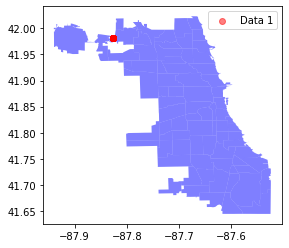

In [112]:
#das ganze visualisieren:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
communities_gdf.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched_drop_com.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [114]:
unmatched_drop_com.sort_values('dlat')

,dlong,dlat,geometry,index_right,area_num_1
784724,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
5029235,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
5001259,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
4970398,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
4649537,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
...,...,...,...,...,...
2821099,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
2751678,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
2650598,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
3111834,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN


In [115]:
unmatched_drop_com.groupby('dlat').count()

,dlong,geometry,index_right,area_num_1
dlat,,,,
41.980507,92,92,0,0


In [127]:
df.loc[unmatched_drop_com.index,'Dropoff Community Area'].value_counts()

10.0    92
Name: Dropoff Community Area, dtype: int64

In [136]:
matched_drop_comm_gdf.fillna(10,inplace=True)

In [137]:
mask=df['Dropoff Community Area'].notna()
test=df.loc[mask,'Dropoff Community Area'].astype('int')==matched_drop_comm_gdf.loc[mask,'area_num_1'].astype('int')

In [138]:
test.value_counts()

True    5145253
dtype: int64

In [140]:
#hier fuelle ich nun die daten in df. also die 14.983 fehlenden dropoff communitys
df.loc[matched_drop_comm_gdf.index,'Dropoff Community Area']=matched_drop_comm_gdf['area_num_1']

In [141]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           4020515
Dropoff Census Tract          4020515
Pickup Community Area         5160074
Dropoff Community Area        5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid Location     5160236
new_TaxiID                    5160236
dur_min                       5160236
dtype: int64

In [142]:
#kreirt ein geopandas dataframe
geographical_pickup_gdf=gpd.GeoDataFrame(look[['plong','plat']], geometry=gpd.points_from_xy(look.plong, look.plat))

In [143]:
#sucht nach den Pickup communites der jeweiligen Pickup location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-143-88b63e18aa74>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [144]:
unmatched_pick_com=matched_pick_comm_gdf[matched_pick_comm_gdf['area_num_1'].isna()]

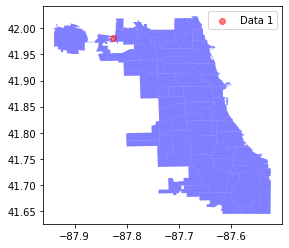

In [145]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
communities_gdf.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched_pick_com.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [146]:
unmatched_pick_com

,plong,plat,geometry,index_right,area_num_1
426916,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN


In [147]:
df.loc[426916,'Pickup Community Area']

10.0

In [148]:
matched_pick_comm_gdf['area_num_1'].fillna(10,inplace=True)

,plong,plat,geometry,index_right,area_num_1
0,-87.620993,41.884987,POINT (-87.62099 41.88499),37.0,32
54,-87.711211,41.938666,POINT (-87.71121 41.93867),21.0,21
784,-87.913625,41.980264,POINT (-87.91362 41.98026),74.0,76
122573,-87.769615,41.792592,POINT (-87.76962 41.79259),54.0,56
122574,-87.620993,41.884987,POINT (-87.62099 41.88499),37.0,32
...,...,...,...,...,...
6195692,-87.631407,41.871016,POINT (-87.63141 41.87102),37.0,32
6195693,-87.620993,41.884987,POINT (-87.62099 41.88499),37.0,32
6195694,-87.649489,41.922686,POINT (-87.64949 41.92269),67.0,7
6195695,-87.626215,41.892508,POINT (-87.62621 41.89251),36.0,8


In [149]:
mask=df['Pickup Community Area'].notna()
test=df.loc[mask,'Pickup Community Area'].astype('int')==matched_pick_comm_gdf.loc[mask,'area_num_1'].astype('int')

In [150]:
test.value_counts()

True    5160074
dtype: int64

In [151]:
#hier fuelle ich nun die daten in df. also die 162 fehlenden pickup communitys
df.loc[matched_pick_comm_gdf.index,'Pickup Community Area']=matched_pick_comm_gdf['area_num_1']

In [152]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           4020515
Dropoff Census Tract          4020515
Pickup Community Area         5160236
Dropoff Community Area        5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid Location     5160236
new_TaxiID                    5160236
dur_min                       5160236
dtype: int64

In [153]:
#nun das gleiche mit pickup und drop off cencus tract machen:
census=gpd.read_file('Census Tracts - 2010.geojson')

In [154]:
#geodrop = dropoffdata fuer den census tract dropoff
geodrop_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.dlong, look.dlat))
matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-154-fb201ae4c96f>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')


In [155]:
#hier sind alle unmatched variablen auch von chicago ohare. also kann ich die auch füllen mit chicago ohare 
#cencus trac mit nummer 17031980000
unmatched=matched_gdf[matched_gdf['geoid10'].isna()]
unmatched.sort_values(['dlat'])
#die 14983 fehlenden eintraege sind die gleiche, die bei der community area fehlen...

,plat,plong,dlat,dlong,geometry,index_right,geoid10
122584,41.982273,-87.841586,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4528711,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4529515,41.867902,-87.642959,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4529840,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4529917,41.892508,-87.626215,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
...,...,...,...,...,...,...,...
2914267,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
2914565,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
2914997,41.878667,-87.671654,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
2912971,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN


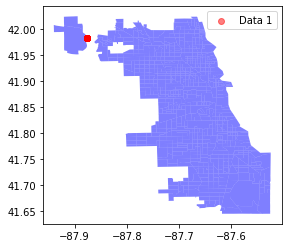

In [156]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
census.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [157]:
unmatched.groupby('dlat').count()

,plat,plong,dlong,geometry,index_right,geoid10
dlat,,,,,,
41.982775,14983,14983,14983,14983,0,0


In [159]:
df.loc[unmatched.index,'Dropoff Census Tract'].value_counts()

1.703177e+10    14983
Name: Dropoff Census Tract, dtype: int64

In [162]:
#17031770700 is der census trac, der in dem datensatz census fehlt, und in dem sie eigentlich sind
#17031980000 is der census trac von chicago ohare, zu dem die dropoffs quasi zaehlen...
matched_gdf['geoid10'].fillna(17031770700, inplace=True)


In [163]:
#testen ob die alten mit den neuen tract uebereinstimmen!
mask=df['Dropoff Census Tract'].notna()
test=df.loc[mask,'Dropoff Census Tract'].astype('int')==matched_gdf.loc[mask,'geoid10'].astype('int')

In [166]:
test.value_counts()

True    4020515
dtype: int64

In [167]:
#jetzt kann ich uebertragen
df.loc[:,'Dropoff Census Tract']=matched_gdf['geoid10']

In [168]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           4020515
Dropoff Census Tract          5160236
Pickup Community Area         5160236
Dropoff Community Area        5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid Location     5160236
new_TaxiID                    5160236
dur_min                       5160236
dtype: int64

In [170]:
#geopick = pickupdata fuer den census tract pickup
geopick_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.plong, look.plat))
matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-170-37a7629ca517>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')


In [171]:
#hier sind alle unmatched variablen auch von chicago ohare. also kann ich die auch füllen mit chicago ohare 
#cencus trac mit nummer 17031980000
unmatchedp=matched_gdf[matched_gdf['geoid10'].isna()]
unmatchedp.sort_values(['plat'])
#die 14983 fehlenden eintraege sind die gleiche, die bei der community area fehlen...

,plat,plong,dlat,dlong,geometry,index_right,geoid10
122585,41.982775,-87.877305,41.979071,-87.903040,POINT (-87.87731 41.98278),NaN,NaN
4116829,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4189920,41.982775,-87.877305,41.979071,-87.903040,POINT (-87.87731 41.98278),NaN,NaN
4227635,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
4243569,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
...,...,...,...,...,...,...,...
2930345,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
2937976,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
2984732,41.982775,-87.877305,41.885281,-87.657233,POINT (-87.87731 41.98278),NaN,NaN
2206922,41.982775,-87.877305,41.895033,-87.619711,POINT (-87.87731 41.98278),NaN,NaN


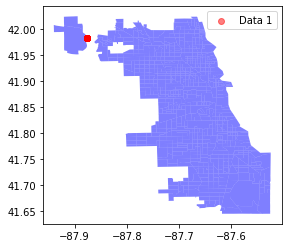

In [172]:
#das ganze visualisieren:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
census.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatchedp.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [176]:
#anscheinend sind alle anfaenge genau gleich
unmatchedp.groupby('plat').count()

,plong,dlat,dlong,geometry,index_right,geoid10
plat,,,,,,
41.982775,162,162,162,162,0,0


In [177]:
#welcher census tract fehlt?
df.loc[unmatchedp.index,'Pickup Census Tract'].value_counts()

1.703177e+10    162
Name: Pickup Census Tract, dtype: int64

In [ ]:
unmatchedp

In [184]:
df.loc[122585,'Pickup Census Tract']

17031770700.0

In [191]:
#nun also die fehlenden werte auffuellen mit 17031770700
matched_gdf['geoid10'].fillna(17031770700, inplace=True)

In [193]:
#testen ob die alten mit den neuen tract uebereinstimmen!
mask=df['Pickup Census Tract'].notna()
test=df.loc[mask,'Pickup Census Tract'].astype('int')==matched_gdf.loc[mask,'geoid10'].astype('int')

In [194]:
test.value_counts()

True    4020515
dtype: int64

In [195]:
#jetzt kann ich uebertragen
df.loc[:,'Pickup Census Tract']=matched_gdf['geoid10']

In [196]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           5160236
Dropoff Census Tract          5160236
Pickup Community Area         5160236
Dropoff Community Area        5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid Location     5160236
new_TaxiID                    5160236
dur_min                       5160236
dtype: int64

In [178]:
#allgemein zu wissen, die location sind irgendwie nicht komplett individuell...
df.groupby('Pickup Centroid Latitude').count()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Trip Total,Payment Type,Company,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
Pickup Centroid Latitude,,,,,,,,,,,,,,,,,,,,,
41.660136,20,20,20,20,0,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
41.663671,27,27,27,27,0,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
41.673820,210,210,210,210,0,210,210,210,210,210,...,210,210,210,210,210,210,210,210,210,210
41.689730,126,126,126,126,0,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
41.690633,307,307,307,307,0,307,307,307,307,307,...,307,307,307,307,307,307,307,307,307,307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42.015720,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
42.015934,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
42.016011,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


# Füge die Wetter daten hinzu!

In [197]:
#wetterdatensatzladen
weather_df=pd.read_csv('weather_clean_final.csv',parse_dates=['date_time'])
weather_df=weather_df.drop('Unnamed: 0',axis=1)

In [198]:
# hier die timestamps abbrunden um gleich zusammenzufuehren
#also den datensatz ein bissche erweitern
weather_df.loc[:,'hour']=weather_df['date_time'].apply(lambda h :h.hour)
weather_df.loc[:,'day']=weather_df['date_time'].apply(lambda d :d.day)
weather_df.loc[:,'month']=weather_df['date_time'].apply(lambda m :m.month)

In [199]:
weather_df

,date_time,avg_temp,precip,hour,day,month
0,2017-01-01 00:00:00,-0.6,0.0,0,1,1
1,2017-01-01 01:00:00,-2.2,0.0,1,1,1
2,2017-01-01 02:00:00,-2.8,0.0,2,1,1
3,2017-01-01 03:00:00,-3.3,0.0,3,1,1
4,2017-01-01 04:00:00,-3.3,0.0,4,1,1
...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,0.0,19,31,12
8756,2017-12-31 20:00:00,-10.6,0.0,20,31,12
8757,2017-12-31 21:00:00,-10.6,0.0,21,31,12
8758,2017-12-31 22:00:00,-11.7,0.0,22,31,12


In [200]:
#hier soll gemerged werden, einmal werden die wetterdaten pro trip dazugeholt, dafuer hier
#erstmal neue columns erstellen mit der abgerundeten zeiten(stunde/monat/ etc)
#auch fuer spaetere analysen wichtig
df['date']=df['Trip Start Timestamp'].apply(lambda d: pd.to_datetime(d).floor('d'))
df['s_hour']=df['Trip Start Timestamp'].apply(lambda h: h.hour)
df['s_day']=df['Trip Start Timestamp'].apply(lambda d: d.day)
df['weekday']=df['Trip Start Timestamp'].apply(lambda w: w.dayofweek)
df['s_month']=df['Trip Start Timestamp'].apply(lambda m: m.month)

In [201]:
df=df.merge(weather_df[['avg_temp','precip','hour','day','month']],how='left',left_on=['s_hour','s_day','s_month'],right_on=['hour','day','month'])
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,date,s_hour,s_day,weekday,s_month,avg_temp,precip,hour,day,month
0,2017-05-12 21:00:00,2017-05-12 21:15:00,865.0,4.6,17031320100,17031070300,32,7,15.00,2.55,...,2017-05-12,21,12,4,5,21.1,0.0,21,12,5
1,2017-04-27 11:30:00,2017-04-27 11:30:00,20.0,0.0,17031210601,17031210601,21,21,3.25,0.65,...,2017-04-27,11,27,3,4,14.4,1.0,11,27,4
2,2017-06-29 01:00:00,2017-06-29 01:15:00,1560.0,17.1,17031980000,17031081000,76,8,33.65,0.00,...,2017-06-29,1,29,3,6,25.6,0.0,1,29,6
3,2017-04-27 21:00:00,2017-04-27 21:30:00,2082.0,18.2,17031560800,17031062200,56,6,45.75,7.46,...,2017-04-27,21,27,3,4,7.8,0.0,21,27,4
4,2017-05-03 14:15:00,2017-05-03 14:15:00,474.0,0.9,17031320100,17031081401,32,8,6.25,1.00,...,2017-05-03,14,3,2,5,9.4,0.0,14,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160231,2017-10-08 16:30:00,2017-10-08 17:45:00,4260.0,28.5,17031839000,17031980100,32,56,72.25,0.00,...,2017-10-08,16,8,6,10,20.6,0.0,16,8,10
5160232,2017-10-22 18:00:00,2017-10-22 18:15:00,540.0,0.0,17031320100,17031833000,32,28,7.25,1.65,...,2017-10-22,18,22,6,10,20.0,0.0,18,22,10
5160233,2017-10-23 11:15:00,2017-10-23 11:15:00,360.0,0.0,17031071100,17031062200,7,6,6.00,3.00,...,2017-10-23,11,23,0,10,10.6,1.0,11,23,10
5160234,2017-10-07 13:45:00,2017-10-07 14:00:00,900.0,3.1,17031081500,17031081800,8,8,12.25,2.65,...,2017-10-07,13,7,5,10,20.0,0.0,13,7,10


In [202]:
#doppelte zeiten brauchen wir nicht
df.drop(['s_hour','s_day','s_month'],axis=1, inplace=True)

In [203]:
df.count()

Trip Start Timestamp          5160236
Trip End Timestamp            5160236
Trip Seconds                  5160236
Trip Miles                    5160236
Pickup Census Tract           5160236
Dropoff Census Tract          5160236
Pickup Community Area         5160236
Dropoff Community Area        5160236
Fare                          5160236
Tips                          5160236
Tolls                         5160236
Extras                        5160236
Trip Total                    5160236
Payment Type                  5160236
Company                       5160236
Pickup Centroid Latitude      5160236
Pickup Centroid Longitude     5160236
Pickup Centroid Location      5160236
Dropoff Centroid Latitude     5160236
Dropoff Centroid Longitude    5160236
Dropoff Centroid Location     5160236
new_TaxiID                    5160236
dur_min                       5160236
date                          5160236
weekday                       5160236
avg_temp                      5160236
precip      

In [204]:
df.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company',
       'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid Location', 'new_TaxiID',
       'dur_min', 'date', 'weekday', 'avg_temp', 'precip', 'hour', 'day',
       'month'],
      dtype='object')

In [205]:
df.to_csv('taxi_19_may_big.csv')

In [206]:
df_essentials=df[['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips',
       'Tolls', 'Extras','Payment Type', 'Company',
       'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
        'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude',
       'new_TaxiID']]

In [207]:
df_essentials.to_csv('taxi_essentials.csv')